In [3]:
import numpy as np
from numpy import savetxt, loadtxt
import matplotlib.pyplot as plt

In [4]:
data_size = 100
noise = 1 # the higher the noisier

# we now open the file input_vectors.txt so that the vhd code can process it
f = open("input.txt", "w")

input_sig = []

for i in range(data_size):
    sig = 60*(np.sin(i/10)+ noise)
    noise = -noise
    f.write('%d\n' % sig.astype(int)) # we write it as an int
    input_sig.append(sig.astype(int)) # we write it as an int

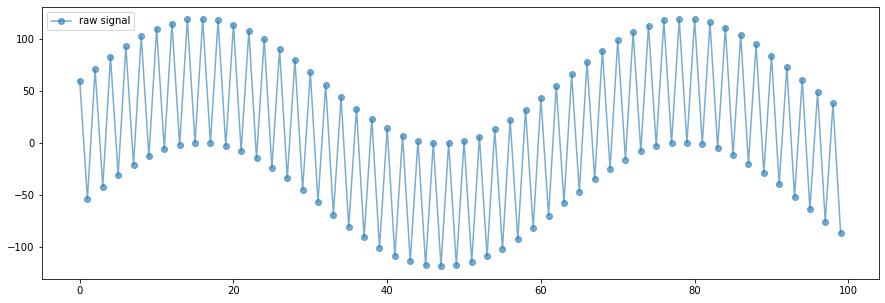

In [5]:
t = np.arange(len(input_sig)) # array for the x coordinate, just for displaying

plt.figure(figsize=(15, 5))

plt.plot(t, input_sig, '-o',alpha=.6,label='raw signal')
plt.legend(loc="upper left")

In [6]:
# After being computed on the actual FPGA

In [7]:
# we save the result obtained using the testbench in a array named tb
fpga = [0,0,0,0,0,3,-2,0,0,0,0,0,0,0,0,3,-2,6,-2,6,-2,6,-2,6,-2,6,-2,6,-50,-32,6,-2,6,-2,6,-2,6,-2,6,-2,3,-2,1,-2,1,-2,1,-2,1,-2,-3,-6,-6,-6,-6,-6,-8,-8,-8,-8,-8,-8,-8,-8,-8,-5,-3,-3,-3,-3,-3,-3,-3,-3,-2,1,-2,4,-2,4,-2,4,-2,4,-2,4,-2,5,-2,7,-2,7,-2,7,-2,7,-2,7,-2,3]

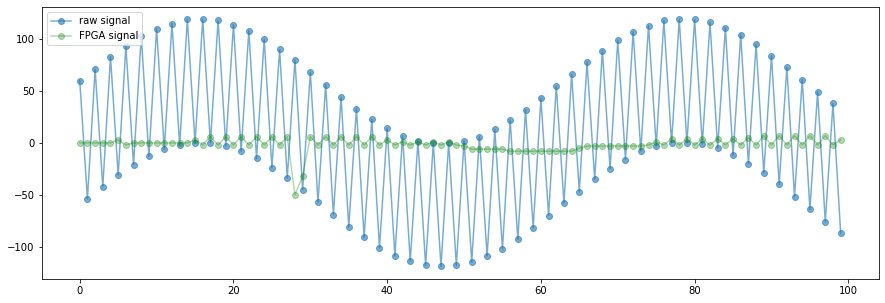

In [8]:
plt.figure(figsize=(15, 5))

plt.plot(t, input_sig, '-o',alpha=.6,label='raw signal')
plt.plot(t, fpga, '-o', color='g',alpha=.3,label='FPGA signal')
#plt.title("")
#plt.xlim(0,130) #just for the latex report
plt.legend(loc="upper left")